In [1]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import time

sys.path.append("../")
from proj_mod import training, data_processing
importlib.reload(training);
importlib.reload(data_processing);

In [2]:
device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


## Data loading

In [3]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")

In [4]:
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")
df_RV_ts.pivot(index="row_id",columns=["sub_int_num"],values=["sub_int_RV"])

sub_int_RV                                                        \
sub_int_num         1         2         3         4         5             6    
row_id                                                                         
0-1000        0.000341  0.000000  0.000023  0.000000  0.000170  3.818799e-07   
0-10000       0.000290  0.000191  0.000087  0.000193  0.000241  3.154886e-04   
0-10005       0.000000  0.000000  0.001554  0.002177  0.002303  4.375100e-04   
0-10017       0.000142  0.000142  0.001464  0.001086  0.000068  6.771948e-05   
0-10030       0.000327  0.000058  0.000293  0.000842  0.000120  2.586782e-04   
...                ...       ...       ...       ...       ...           ...   
99-9972       0.000197  0.000181  0.000171  0.000172  0.000369  2.503467e-04   
99-9973       0.000821  0.000346  0.000691  0.001591  0.000863  9.650211e-04   
99-9976       0.000569  0.001101  0.001002  0.000430  0.000797  7.203531e-04   
99-9988       0.000040  0.000069  0.000123  0.000056  0.000016  1.957402e-04   
99-9993       0.000249  0.000179  0.000155  0.000025  0.000325  1.798617e-04   

                                                     ...                      \
sub_int_num        7         8         9         10  ...        51        52   
row_id                                               ...                       
0-1000       0.000089  0.000552  0.000012  0.000000  ...  0.000265  0.000000   
0-10000      0.000000  0.000247  0.000265  0.000000  ...  0.000202  0.000375   
0-10005      0.000617  0.001199  0.002306  0.001215  ...  0.000000  0.000486   
0-10017      0.000899  0.000064  0.000593  0.000451  ...  0.000029  0.000000   
0-10030      0.000221  0.000436  0.000099  0.000008  ...  0.000410  0.000437   
...               ...       ...       ...       ...  ...       ...       ...   
99-9972      0.000349  0.000356  0.000390  0.000050  ...  0.000075  0.000185   
99-9973      0.000504  0.001925  0.000641  0.000382  ...  0.001081  0.001095   
99-9976      0.000586  0.000538  0.000570  0.000781  ...  0.000508  0.000406   
99-9988      0.000071  0.000095  0.000063  0.000030  ...  0.000034  0.000176   
99-9993      0.000080  0.000125  0.000126  0.000205  ...  0.000099  0.000370   

                                                                   \
sub_int_num        53        54        55        56            57   
row_id                                                              
0-1000       0.000214  0.000003  0.000000  0.000118  2.313288e-04   
0-10000      0.000616  0.000564  0.000000  0.000023  3.777703e-08   
0-10005      0.000050  0.001761  0.001617  0.001801  2.552987e-03   
0-10017      0.001293  0.002092  0.000994  0.000848  3.104404e-03   
0-10030      0.000004  0.000215  0.000457  0.000183  4.842470e-04   
...               ...       ...       ...       ...           ...   
99-9972      0.000314  0.000318  0.000115  0.000143  9.916624e-05   
99-9973      0.000425  0.000789  0.001295  0.000596  1.862600e-03   
99-9976      0.000662  0.000338  0.000710  0.000179  5.946683e-04   
99-9988      0.000140  0.000129  0.000175  0.000019  1.440137e-04   
99-9993      0.000929  0.000328  0.000251  0.000204  2.728767e-04   

                                               
sub_int_num            58        59        60  
row_id                                         
0-1000       1.060893e-05  0.000111  0.000288  
0-10000      3.777703e-08  0.000020  0.000310  
0-10005      5.364106e-04  0.000872  0.000000  
0-10017      1.224910e-03  0.001316  0.003287  
0-10030      0.000000e+00  0.000756  0.000005  
...                   ...       ...       ...  
99-9972      1.809852e-04  0.000334  0.000089  
99-9973      7.668418e-04  0.001035  0.002115  
99-9976      1.509652e-04  0.000388  0.000403  
99-9988      3.200939e-05  0.000041  0.000007  
99-9993      2.108380e-04  0.000126  0.000353  

[428932 rows x 60 columns]

In [5]:
RV_tab=pd.read_csv("../processed_data/RV_by_row_id.csv")
RV_tab

,time_id,RV,row_id,stock_id
0,5,0.002185,93-5,93
1,11,0.001205,93-11,93
2,16,0.001461,93-16,93
3,31,0.001693,93-31,93
4,62,0.001296,93-62,93
...,...,...,...,...
428927,32751,0.002337,104-32751,104
428928,32753,0.001500,104-32753,104
428929,32758,0.002272,104-32758,104
428930,32763,0.001949,104-32763,104


In [6]:
# Creates tabular data, most specifically 'emb_id'
unique_ids = sorted(RV_tab['stock_id'].unique())
id_to_emb = {stock_id: i for i, stock_id in enumerate(unique_ids)}
RV_tab['emb_id'] = RV_tab['stock_id'].map(id_to_emb)
RV_tab

,time_id,RV,row_id,stock_id,emb_id
0,5,0.002185,93-5,93,81
1,11,0.001205,93-11,93,81
2,16,0.001461,93-16,93,81
3,31,0.001693,93-31,93,81
4,62,0.001296,93-62,93,81
...,...,...,...,...,...
428927,32751,0.002337,104-32751,104,92
428928,32753,0.001500,104-32753,104,92
428929,32758,0.002272,104-32758,104,92
428930,32763,0.001949,104-32763,104,92


In [7]:
df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)
df_target

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


## Dataset creation

In [8]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],tab_features=["emb_id"],df_ts_feat=df_RV_ts,df_tab_feat=RV_tab,df_target=df_target)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



In [9]:
train_dataset[20000]

(tensor([4.6594e-04, 1.5794e-04, 2.6052e-04, 2.0006e-04, 4.6036e-04, 4.1584e-04,
         9.8932e-04, 4.7264e-04, 2.1441e-04, 2.9363e-05, 2.4447e-04, 2.9892e-04,
         7.5965e-04, 6.9540e-04, 6.2064e-05, 9.8745e-04, 1.1972e-03, 5.2220e-04,
         1.2480e-04, 3.2021e-04, 2.0767e-04, 2.9159e-04, 1.3637e-04, 5.0568e-04,
         7.6126e-04, 5.4608e-05, 5.1065e-04, 5.1155e-04, 1.2982e-04, 1.5398e-04,
         6.1349e-04, 8.6339e-04, 4.7770e-04, 6.8327e-04, 5.8174e-04, 1.9467e-05,
         2.8003e-04, 3.1872e-04, 6.9253e-04, 8.4858e-05, 5.5608e-04, 1.2923e-03,
         7.3301e-04, 3.3100e-04, 3.8636e-04, 1.3472e-04, 4.8604e-04, 2.2667e-04,
         5.7036e-04, 2.3896e-04, 6.0563e-04, 2.2564e-04, 4.4306e-04, 1.6629e-04,
         2.7551e-04, 3.5369e-04, 3.3014e-04, 4.8192e-04, 5.2923e-04, 3.0226e-04,
         9.0000e+01]),
 tensor([0.0053]))

In [10]:
train_dataset.get_row_id(20000)

'102-4084'

In [11]:
# The assigned 'emb_id' looks good
id_to_emb

{np.int64(0): 0,
 np.int64(1): 1,
 np.int64(2): 2,
 np.int64(3): 3,
 np.int64(4): 4,
 np.int64(5): 5,
 np.int64(6): 6,
 np.int64(7): 7,
 np.int64(8): 8,
 np.int64(9): 9,
 np.int64(10): 10,
 np.int64(11): 11,
 np.int64(13): 12,
 np.int64(14): 13,
 np.int64(15): 14,
 np.int64(16): 15,
 np.int64(17): 16,
 np.int64(18): 17,
 np.int64(19): 18,
 np.int64(20): 19,
 np.int64(21): 20,
 np.int64(22): 21,
 np.int64(23): 22,
 np.int64(26): 23,
 np.int64(27): 24,
 np.int64(28): 25,
 np.int64(29): 26,
 np.int64(30): 27,
 np.int64(31): 28,
 np.int64(32): 29,
 np.int64(33): 30,
 np.int64(34): 31,
 np.int64(35): 32,
 np.int64(36): 33,
 np.int64(37): 34,
 np.int64(38): 35,
 np.int64(39): 36,
 np.int64(40): 37,
 np.int64(41): 38,
 np.int64(42): 39,
 np.int64(43): 40,
 np.int64(44): 41,
 np.int64(46): 42,
 np.int64(47): 43,
 np.int64(48): 44,
 np.int64(50): 45,
 np.int64(51): 46,
 np.int64(52): 47,
 np.int64(53): 48,
 np.int64(55): 49,
 np.int64(56): 50,
 np.int64(58): 51,
 np.int64(59): 52,
 np.int64(60)

In [12]:
df_target[df_target["row_id"]=="102-4084"]

,stock_id,time_id,target,row_id
345167,102,4084,0.005318,102-4084


## Model

In [17]:
# TODO: The splitting of x, as of now, only works for this particular dataset, doing the splitting using the capabilites of RV_Dataset remains to be done.
# Maybe the dataset should have an internal variable that tells us how many differet stocks there are in order to pass that to this model directly....?
# Is there a way to reuse RV_RNN_conv in RV_RNN_conv to avoid code duplication?


class RV_RNN_conv_emb(nn.Module):        
    #Created 07/02/25 see RNN_with_frozen_conv.ipynb for documentation. 
    #Modified 07/08/25 Added LSTM and GRU options
    #NEW n_stocks, stock_emb_dim
    def __init__(self,n_diff,rnn_num_layer,rnn_drop_out,rnn_type="rnn",rnn_act="tanh",proj_dim=32,rnn_hidden_size=32,input_scaler=10000, n_stocks=112, stock_emb_dim=8):
        """
        :param n_diff: Decides how many derivative features is wanted in the time series. 
        :param rnn_num_layer: num_layer parameter for rnn. 
        :param rnn_drop_out: dropout parameter for rnn. 
        :param rnn_act: Defaulted to "tanh". Nonlinearity parameter for rnn. 
        :param proj_dim: Defaulted to 32. Decided the dimension of projection before feeding into rnn. 
        :param rnn_hidden_size: Defaulted to 32. The hidden_size parameter for rnn. 
        :param input_scaler: Defaulted to 10000. Set a scaling to input, a lot of timeseries values of our data are extremely close to zero. 
        :param rnn_type: 'rnn', 'lstm', or 'gru'
        """
        super().__init__()
        
        self.input_scaler=input_scaler
        self.frozen_conv=training.frozen_diff_conv(n_diff=n_diff)
        self.linear_proj_input=nn.Linear(n_diff+1,proj_dim)

        self.rnn_type = rnn_type

        # NEW
        self.stock_embedding = nn.Embedding(num_embeddings=n_stocks, embedding_dim=stock_emb_dim)
        rnn_input_size = proj_dim + stock_emb_dim
        
        if rnn_type == "rnn":
            # CHANGED rnn_input_size
            self.RNN_layer=nn.RNN(input_size=rnn_input_size,
                                  hidden_size=rnn_hidden_size,
                                  num_layers=rnn_num_layer,
                                  nonlinearity=rnn_act,
                                  batch_first=True,
                                  dropout=rnn_drop_out)
        elif rnn_type == "lstm":
            if rnn_act is not None:
                print(f"Warning: rnn_act='{rnn_act}' is ignored when using rnn_type='lstm'")
            # CHANGED rnn_input_size
            self.RNN_layer = nn.LSTM(input_size=rnn_input_size,
                                     hidden_size=rnn_hidden_size,
                                     num_layers=rnn_num_layer,
                                     batch_first=True,
                                     dropout=rnn_drop_out)
        elif rnn_type == "gru":
            if rnn_act is not None:
                print(f"Warning: rnn_act='{rnn_act}' is ignored when using rnn_type='gru'")
            # CHANGED rnn_input_size
            self.RNN_layer = nn.GRU(input_size=rnn_input_size,
                                    hidden_size=rnn_hidden_size,
                                    num_layers=rnn_num_layer,
                                    batch_first=True,
                                    dropout=rnn_drop_out)
        else:
            raise ValueError(f"Unsupported rnn_type: {rnn_type}")
        
        self.linear_post_rnn=nn.Linear(rnn_hidden_size,1)
        self.frozen_list=["frozen_conv"] 
        
    def forward(self,x):
        # NEW
        x, emb_id = x[:, :-1], x[:, -1].long()
        
        #First, scale the input, and unsqueese to add in one dimension in dim 1 as channel. This is needed for convolution. 
        x*=self.input_scaler
        x=torch.unsqueeze(x,dim=1)
        x=self.frozen_conv(x)
        x=x.permute(0,2,1)
        x=self.linear_proj_input(x)

        # NEW
        stock_emb = self.stock_embedding(emb_id)
        stock_emb = stock_emb.unsqueeze(1).expand(-1, x.shape[1], -1)
        x = torch.cat([x, stock_emb], dim=-1)
        
        
        x=self.RNN_layer(x)[0]
        x=self.linear_post_rnn(x)
        
        return torch.sum(x,dim=1)/self.input_scaler

## Model creation

In [26]:
RNN_emb_model=RV_RNN_conv_emb(n_diff=2, rnn_type="rnn",rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=10000, stock_emb_dim=8).to(device=device)

import torch.optim as optim

optimizer=optim.Adam(RNN_emb_model.parameters(),lr=1e-3)

train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=512,shuffle=True, num_workers=4, pin_memory=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=512,shuffle=True, num_workers =4, pin_memory=True)

## Training

In [27]:
train_loss=[]
val_loss=[]

training.reg_training_loop_rmspe(optimizer=optimizer,model=RNN_emb_model,train_loader=train_loader,val_loader=test_loader,list_train_loss=train_loss,list_val_loss=val_loss,device=device,n_epochs=100,ot_steps=10,report_interval=5,eps=0,scaler=1)

At  1.1174654960632324  epoch  1 has training loss  tensor(0.2719, device='cuda:0')  and validation loss  tensor(0.2381, device='cuda:0') .

At  6.246473073959351  epoch  5 has training loss  tensor(0.2468, device='cuda:0')  and validation loss  tensor(0.2297, device='cuda:0') .

At  12.686989307403564  epoch  10 has training loss  tensor(0.2454, device='cuda:0')  and validation loss  tensor(0.2312, device='cuda:0') .

At  19.07281517982483  epoch  15 has training loss  tensor(0.2444, device='cuda:0')  and validation loss  tensor(0.2294, device='cuda:0') .

At  25.592143774032593  epoch  20 has training loss  tensor(0.2441, device='cuda:0')  and validation loss  tensor(0.2279, device='cuda:0') .

At  32.05854272842407  epoch  25 has training loss  tensor(0.2434, device='cuda:0')  and validation loss  tensor(0.2257, device='cuda:0') .

At  38.510169982910156  epoch  30 has training loss  tensor(0.2431, device='cuda:0')  and validation loss  tensor(0.2266, device='cuda:0') .

At  44.9940

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('linear_proj_input.weight',
              tensor([[-0.2391, -0.2835, -0.3769],
                      [-0.0232, -0.0158,  0.0041],
                      [ 0.1326,  0.0313, -0.1581],
                      [-0.0279, -0.4266, -0.0033],
                      [ 0.0254,  0.5010,  0.2733],
                      [ 0.1496,  0.5480,  0.3960],
                      [-0.0914,  0.3331,  0.3084],
                      [-0.1617, -0.3457, -0.2240],
                      [ 0.3833, -0.4110, -0.3692],
                      [ 0.2893,  0.5380, -0.3828],
                      [ 0.2390,  0.2000,  0.3397],
                      [ 0.0143,  0.2499,  0.1275],
                      [ 0.0106, -0.3946, -0.2692],
                      [ 0.0897, -0.2091, -0.1350],
                      [-0.1630,  0.2939,  0.3648],
                      [-0.4276, -0.6178, -0.3326],
                      [-0.1129, -0.313

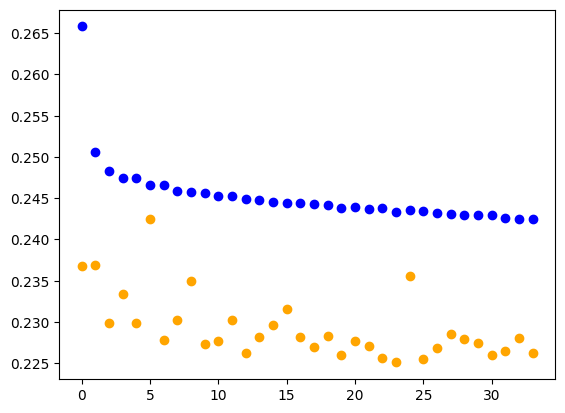

In [23]:
train_loss=[x.cpu() for x in train_loss]
val_loss=[x.cpu() for x in val_loss]

import matplotlib.pyplot as plt 

x=np.arange(len(train_loss))

plt.scatter(x,train_loss,c="blue")
plt.scatter(x,val_loss,c="orange")